## Assume that con is uniformly distruibuted on the interval $[s, h]$

In [1]:
import numpy as np
import logging
import matplotlib.pyplot as plt

import ray

logging.basicConfig()
logger = logging.getLogger('dual')
logger.setLevel(logging.INFO)

In [2]:
# -*- coding: utf-8 -*-
"""
@Created at 2022/4/29 10:21
@Author: Kurt
@file:tools_dual.py
@Desc:
"""
EPSILON = 0.000001


def myround(num):
    num = num if abs(num) > EPSILON else 0
    return num


def scenario_check(pon, poffs, s, h, c):
    if myround(poffs - 1 / 2 * pon - 2 * c) > 0:
        if myround(pon - 4 * c) <= 0:
            if myround(h - poffs + pon) >= 0:
                return 1
            else:
                return 2
        else:
            return 3
    else:
        return 4


def calculate_prior_demand(pon, poffs, c, s, h, scenario):
    if scenario == 1:
        alpha_ss_prior = 1 / (h - s) * (1 - min(1, poffs + 2 * c)) * (h - max(s, poffs - pon))
        if myround(s - 2 * c + 1 / 2 * pon) <= 0:
            alpha_o = 1 / (2 * (h - s)) * (min(2 * c - 1 / 2 * pon, 1 / 2 * (1 - 3 / 2 * pon)) - s) * (
                    2 - min(1, 1 / 2 * pon + 4 * c) - min(1, 2 * s + 3 / 2 * pon))
            alpha_so_prior = 1 / (2 * (h - s)) * (poffs - pon - min(poffs - pon, max(s, 2 * c - 1 / 2 * pon))) * (
                    2 - min(1, poffs - 2 * c) - min(1, 1 / 2 * pon + 4 * c))
        elif myround(s - poffs + pon) <= 0:
            alpha_o = 0
            alpha_so_prior = 1 / (2 * (h - s)) * (min(poffs - pon, 1 - pon - 2 * c) - s) * (
                    2 - min(1, poffs + 2 * c) - min(1, pon + s + 2 * c))
        else:
            alpha_o = 0
            alpha_so_prior = 0
    elif scenario == 2:
        alpha_ss_prior = 0
        if myround(h - 2 * c + 1 / 2 * pon) > 0:
            #  if s<2*c-1/2*pon
            if myround(s - 2 * c + 1 / 2 * pon) <= 0:
                alpha_o = 1 / (2 * (h - s)) * (min(2 * c - 1 / 2 * pon, 1 / 2 * (1 - 3 / 2 * pon)) - s) * (
                        2 - min(1, 1 / 2 * pon + 4 * c) - min(1, 2 * s + 3 / 2 * pon))
                alpha_so_prior = 1 / (2 * (h - s)) * (min(h, 1 - pon - 2 * c) - (2 * c - 1 / 2 * pon)) * (
                        2 - min(1, pon + h + 2 * c) - min(1, 1 / 2 * pon + 4 * c))
            else:
                alpha_o = 0
                alpha_so_prior = 1 / (2 * (h - s)) * (min(h, 1 - pon - 2 * c) - s) * (
                        2 - min(1, pon + h + 2 * c) - min(1, pon + s + 2 * c))
        else:
            alpha_o = 1 / (2 * (h - s)) * (min(h, 1 / 2 * (1 - 3 / 2 * pon)) - s) * (
                    2 - min(1, 2 * h + 3 / 2 * pon) - min(1, 2 * s + 3 / 2 * pon))
            alpha_so_prior = 0
    elif scenario == 3:
        alpha_o = 0
        if myround(poffs - pon) >= 0:
            alpha_so_prior = 1 / (2 * (h - s)) * (
                    min(h, poffs - pon, 1 - pon - 2 * c) - min(s, poffs - pon, 1 - pon - 2 * c)) * (
                                     2 - min(1, poffs + 2 * c, pon + h + 2 * c) - min(1, poffs + 2 * c,
                                                                                      pon + s + 2 * c))
            alpha_ss_prior = 1 / (h - s) * (max(poffs - pon, h) - max(poffs - pon, s)) * (1 - min(1, poffs + 2 * c))
        else:
            alpha_so_prior = 0
            alpha_ss_prior = 1 / (h - s) * (h - s) * (1 - min(1, poffs + 2 * c))
    elif scenario == 4:
        alpha_so_prior = 0
        if myround(1 / 2 * poffs - 3 / 4 * pon + c) >= 0:
            alpha_o = 1 / (2 * (h - s)) * (min(h, 1 / 2 * poffs - 3 / 4 * pon + c, 1 / 2 * (1 - 3 / 2 * pon)) -
                                           min(s, 1 / 2 * poffs - 3 / 4 * pon + c, 1 / 2 * (1 - 3 / 2 * pon))) * (
                              2 - min(1, poffs + 2 * c, 2 * h + 3 / 2 * pon) - min(1, 2 * s + 3 / 2 * pon))
            alpha_ss_prior = 1 / (h - s) * (
                    max(h, 1 / 2 * poffs - 3 / 4 * pon + c) - max(s, 1 / 2 * poffs - 3 / 4 * pon + c)) * (
                                     1 - min(1, poffs + 2 * c))
        else:
            alpha_o = 0
            alpha_ss_prior = 1 / (h - s) * (h - s) * (1 - min(1, poffs + 2 * c))
    else:
        raise Exception("Prior demand cal fail!")

    alpha_o = myround(alpha_o)
    alpha_so_prior = myround(alpha_so_prior)
    alpha_ss_prior = myround(alpha_ss_prior)
    if 0 <= alpha_so_prior <= 1 and 0 <= alpha_ss_prior <= 1 and 0 <= alpha_o <= 1:
        alpha_s = alpha_so_prior + alpha_ss_prior
    else:
        print("c: {}, s:{}, h:{}, pon: {:.3f}, poffs: {:.3f}, scenario: {}".format(
            c, s, h, pon, poffs, scenario))
        print("alpha_o:{:.5f}, alpha_so:{:.5f}, alpha_ss: {:.5f}".format(alpha_o, alpha_so_prior, alpha_ss_prior))
        raise Exception("error prior demand!")

    alpha_l = 1 - alpha_o - alpha_s
    alpha_s = myround(alpha_s)
    alpha_l = myround(alpha_l)

    return alpha_o, alpha_s, alpha_l


def store_utility_compare(loc, pon, poff):
    # a consumer located at [con, theta]. The offline shopping cost c is sunk
    u_ss = 1 / 2 * (loc[1] - poff)
    u_so = 1 / 2 * (loc[1] - pon - loc[0])
    u_l = 0

    if myround(u_ss - max(u_so, u_l)) >= 0:
        return "ss"
    elif myround(u_so - u_l) >= 0:
        return "so"
    else:
        return "l"


def cal_profit(pon, cr, alpha_o, store_profit):
    online_direct_profit = alpha_o * (
            1 / 2 * pon + 1 / 4 * (pon - cr))  # w.p 1/2, we have a=a_H, if a=a_L, w.p. 1/2, product return
    profit = 1 / 2 * online_direct_profit + store_profit  # w.p 1/2, we have b=b_H
    return profit


def cal_store_profit(pon, poff, alpha_ss, alpha_so):
    """
    This method optimizes the retailer's profit from in-store consumers
    """
    store_profit = 1 / 2 * alpha_ss * poff + 1 / 2 * alpha_so * pon  # w.p 1/2, we have a=a_H,
    return 1 / 2 * store_profit  # w.p 1/2, we have b=b_H


def FindRationalExpectations(c, s, h, pon, poffs, scenario, step=0.01):
    max_store_profit = 0
    max_store_price = 0
    max_store_demand_online = 0
    max_store_demand_offline = 0
    for poff in np.arange(0, 1, step):
        store_scenario = store_scenario_check(c=c, s=s, h=h, pon=pon, poffs=poffs, poff=poff, scenario=scenario)
        alpha_so, alpha_ss = calculate_store_demand(c=c, s=s, h=h, pon=pon, poffs=poffs, poff=poff,
                                                    store_scenario=store_scenario)
        current_profit_store = cal_store_profit(pon=pon, poff=poff, alpha_ss=alpha_ss, alpha_so=alpha_so)
        # print("current poff: {:.3}, current store profit: {:.5}".format(poff, current_profit_store))
        if max_store_profit < current_profit_store:
            max_store_demand_online = alpha_so
            max_store_demand_offline = alpha_ss
            max_store_profit = current_profit_store
            max_store_price = poff

    # print("poffs:{:.3}, Max store pirce：{:.3}".format(poffs, max_store_price))

    if abs(poffs - max_store_price) >= EPSILON:
        return False, None, None, None, None  # no RE in current poffs
    else:
        return True, max_store_profit, max_store_price, max_store_demand_online, max_store_demand_offline


def calculate_store_demand_shape1(c,  s, k, h, pon, poffs, poff):
    if myround(h - (poffs - pon + 2 * c)) <= 0:
        # no instore consumer leaves with empty hand.
        alpha_so = 1 / (h - s) * (min(poff - pon, h) - min(poff - pon, k)) * (1 - poffs - 2 * c)
        alpha_ss = 1 / (h - s) * (max(poff - pon, h) - max(poff - pon, k)) * (1 - poffs - 2 * c)
    elif myround(k - (poffs - pon + 2 * c)) <= 0:
        alpha_so = 1 / (2 * (h - s)) * (min(poff - pon, h) - min(poffs - pon + 2 * c, poff - pon)) * (
                2 - poff - min(pon + h, poffs + 2 * c))
        +1 / (h - s) * (min(poffs - pon + 2 * c, poff - pon) - min(poff - pon, k)) * (1 - poffs - 2 * c)
        alpha_ss = 1 / (h - s) * (max(h, poff - pon) - max(k, poff - pon)) * (1 - max(poff, poffs + 2 * c))
    else:
        alpha_so = 1 / (2 * (h - s)) * (min(poff - pon, h) - min(poff - pon, k)) * (
                2 - min(poff, pon + h) - (pon + k))
        alpha_ss = 1 / (h - s) * (max(poff - pon, h) - max(poff - pon, k)) * (1 - max(poff, poffs + 2 * c))
    return alpha_so, alpha_ss


def calculate_store_demand_shape2(c, s, k, h, pon, poffs, poff):
    if myround(1 - poffs - 2 * c) >= 0:
        # if there are "ss_prior" consumers before visiting the store.
        if myround(h - (poffs - pon + 2 * c)) > 0:
            # some consumers will leave
            alpha_so = 1 / (2 * (h - s)) * (min(poffs - pon, poff - pon) - min(poff - pon, k)) * (
                    2 - min(poff + 2 * c, poffs + 2 * c) - (pon + k + 2 * c))
            +1 / (h - s) * (min(poffs - pon + 2 * c, poff - pon) - min(poffs - pon, poff - pon)) * (1 - poffs - 2 * c)
            +1 / (2 * (h - s)) * (min(h, poff - pon, poffs - pon + 2 * c) - (poffs - pon + 2 * c)) * (
                    2 - min(pon + h, poff) - (poffs + 2 * c))
            alpha_ss = 1 / (h - s) * (max(h, poff - pon) - max(poff - pon, poffs - pon)) * (
                    1 - max(poffs + 2 * c, poff)) + 1 / (2 * (h - s)) * (max(poffs - pon - max(poff - pon, k), 0)) * (
                               2 - (poffs + 2 * c) - max(pon + k + 2 * c, poff + 2 * c))
        else:
            # all consumers will buy
            alpha_so = 1 / (2 * (h - s)) * (min(poff - pon, poffs - pon) - min(poff - pon, k)) * (
                    2 - min(poffs + 2 * c, poff + 2 * c) - (pon + k + 2 * c))
            +1 / (h - s) * (min(poff - pon, h) - min(poff - pon, poffs - pon)) * (1 - poffs - 2 * c)
            alpha_ss = 1 / (h - s) * (max(h, poff - pon) - max(poffs - pon, poff - pon)) * (1 - poffs - 2 * c)
            +1 / (2 * (h - s)) * (max(poff - pon, poffs - pon) - max(poff - pon, k)) * (
                    2 - (poffs + 2 * c) - max(pon + k + 2 * c, poff + 2 * c))
    else:
        alpha_so = 1 / (2 * (h - s)) * (min(poff - pon, 1 - pon - 2 * c) - min(poff - pon, k)) * (
                2 - min(1, poff + 2 * c) - (pon + k + 2 * c))
        alpha_ss = 1 / (2 * (h - s)) * (max(1 - pon - 2 * c, poff - pon) - max(poff - pon, k)) * (
                1 - max(poff + 2 * c, pon + k + 2 * c))
    return alpha_so, alpha_ss


def calculate_store_demand_shape3(c, s, k, h, pon, poffs, poff):
    if myround(pon + h + 2 * c - 1) <= 0:
        alpha_so = 1 / (2 * (h - s)) * (min(poff - pon, h) - min(poff - pon, k)) * (
                2 - min(poff + 2 * c, pon + h + 2 * c) - (pon + k + 2 * c))
        alpha_ss = 1 / (2 * (h - s)) * (max(poff - pon, h) - max(poff - pon, k)) * (
                2 - max(poff + 2 * c, pon + k + 2 * c) - (pon + h + 2 * c))
    else:
        alpha_so = 1 / (2 * (h - s)) * (min(poff - pon, 1 - pon - 2 * c) - min(poff - pon, k)) * (
                2 - min(poff + 2 * c, 1) - (pon + s + 2 * c))
        alpha_ss = 1 / (2 * (h - s)) * (max(poff - pon, 1 - pon - 2 * c) - max(poff - pon, k)) * (
                1 - max(poff + 2 * c, pon + k + 2 * c))
    return alpha_so, alpha_ss


def calculate_store_demand(c, s, h, pon, poffs, poff, store_scenario):
    # lower bound of con of in-store consumers.
    k = max(s, min(1 / 2 * poffs - 3 / 4 * pon + c, 2 * c - 1 / 2 * pon))

    if store_scenario == 1:
        alpha_so, alpha_ss = calculate_store_demand_shape1(c=c,s=s, k=k, h=h, pon=pon, poffs=poffs, poff=poff)
    elif store_scenario == 2:
        alpha_so, alpha_ss = calculate_store_demand_shape2(c=c,s=s, k=k, h=h, pon=pon, poffs=poffs, poff=poff)
    elif store_scenario == 3:
        alpha_so, alpha_ss = calculate_store_demand_shape3(c=c,s=s, k=k, h=h, pon=pon, poffs=poffs, poff=poff)
    else:
        print("c: {}, k:{}, h:{}, pon: {:.3f}, poffs: {:.3f}, store scenario: {}".format(
            c, k, h, pon, poffs, store_scenario))
        raise Exception("error store scenario!")

    alpha_so = myround(alpha_so)
    alpha_ss = myround(alpha_ss)
    if alpha_ss > 1 or alpha_ss < 0.0 or alpha_so > 1 or alpha_so < 0.0:
        print("c: {}, s:{}, k:{}, h:{}, pon:{}, poffs: {:.3f}, poff: {:.3f},ss: {:.3f},so: {:.3f}".format(
            c, s, k, h, pon, poffs, poff, alpha_ss, alpha_so))
        raise Exception("error in store demand!")
    return alpha_so, alpha_ss

def store_scenario_check(c, s, h, pon, poffs, poff, scenario):
    store_scenario = 0
    if scenario == 1:
        if myround(s - poffs + pon) >= 0:
            store_scenario = 1
        else:
            store_scenario = 2
    elif scenario == 2:
        store_scenario = 3
    elif scenario == 3:
        if myround(s - poffs + pon) > 0:
            store_scenario = 1
        elif myround(h - poffs + pon) > 0:
            store_scenario = 2
        else:
            store_scenario = 3
    else:
        store_scenario = 1

    return store_scenario


In [3]:
class dual:
    def __init__(self, c, cr, s, h, step):
        self.optimal_profit = 0
        self.optimal_pon = 0
        self.optimal_poff = 0
        self.optimal_poffs = 0
        self.prior_demand_online = 0
        self.prior_demand_offline = 0
        self.alpha_o = 0  # true direct online demand
        self.alpha_so = 0  # true showrooming demand
        self.alpha_ss = 0  # true offline demand
        self.consumers = None
        # start to solve the problem
        self.solve_equilibrium(c, cr, s, h, step)

    def solve_equilibrium(self, c, cr, s, h, step):
        for pon in np.arange(0, 1, step):
            logger.debug("-------------------------")
            # given pon, find the RE that maximizes total profit given pon from all potential REs.
            RE_profit_givenpon = 0  # the RE that maximizes total profit given pon.
            poffs_givenpon = 0  # the RE that maximizes total profit given pon.
            poffstar_givenpon = 0  # the RE that maximizes total profit given pon.
            prior_demand_online_givenpon = 0
            prior_demand_offline_givenpon = 0
            alpha_o_givenpon = 0
            alpha_so_givenpon = 0
            alpha_ss_givenpon = 0

            # star to find REs
            for poffs in np.arange(0, 1, step):
                current_scenario = scenario_check(pon=pon, poffs=poffs, c=c, s=s, h=h)
                alpha_o, alpha_s, alpha_l = calculate_prior_demand(pon=pon, poffs=poffs, c=c,
                                                                   s=s, h=h, scenario=current_scenario)

                # if alpha_o > 1 or alpha_o < 0 or alpha_s > 1 or alpha_s < 0: logger.error("c: {}, s:{}, h:{},
                # pon: {:.3f}, poffs: {:.3f}, scenario: {}".format( c, s, h, pon, poffs, current_scenario))
                # logger.error("ex-ante alpha_o:{:.3f}, ex-ante alpha_s: {:.3f}".format(alpha_o, alpha_s)) raise
                # Exception("error prior demand!")

                if not alpha_s:
                    # zero prior store demand, RE exists
                    RE_profit_givenpon_zero_store_demand = cal_profit(pon=pon, cr=cr, alpha_o=alpha_o, store_profit=0)
                    logger.debug("Current poffs causes zero store demand, and online profit: {:.5f}".format(
                        RE_profit_givenpon_zero_store_demand))
                    if myround(RE_profit_givenpon - RE_profit_givenpon_zero_store_demand) < 0:
                        RE_profit_givenpon = RE_profit_givenpon_zero_store_demand
                        poffs_givenpon = poffs
                        poffstar_givenpon = poffs
                        alpha_o_givenpon = alpha_o
                        alpha_so_givenpon = 0
                        alpha_ss_givenpon = 0
                        prior_demand_online_givenpon = alpha_o
                        prior_demand_offline_givenpon = alpha_s

                        logger.info("Given pon={:.4f}, no store demand, a RE is found: poffs: {:.4f}, poff: {:.4f}, "
                                    "prior_online:{:.4f}, total profit: {:.6f}, scenario: {}.".format(
                            pon, poffs_givenpon, poffstar_givenpon, alpha_o, RE_profit_givenpon, current_scenario))
                    continue  # look for the next poffs

                # if prior store demand > 0, start to find a RE
                RE_found, store_profit, store_price, store_demand_online, store_demand_offline = \
                    FindRationalExpectations(c=c, s=s, h=h, pon=pon, poffs=poffs, scenario=current_scenario, step=step)
                # print("store_price:{}".format(store_price))

                if RE_found:
                    potential_RE_profit_givenpon = cal_profit(pon=pon, cr=cr, alpha_o=alpha_o,
                                                              store_profit=store_profit)
                    logger.info(
                        "Given pon={:.4f}, a RE is found."
                        " poffs: {:4f}, poff: {:.4f}, store profit:{:.5f}, prior_online:{:.4f}, prior_store:{:.4f}, "
                        "total profit: {:.5f}, scenario: {}".format(
                            pon, poffs, store_price, store_profit, alpha_o, alpha_s, potential_RE_profit_givenpon,
                            current_scenario))
                    # Given pon, if we find a RE in the current poffs, compare it with optimal RE collected in other
                    if myround(RE_profit_givenpon - potential_RE_profit_givenpon) < 0:
                        RE_profit_givenpon = potential_RE_profit_givenpon
                        poffs_givenpon = store_price
                        poffstar_givenpon = store_price
                        alpha_o_givenpon = alpha_o
                        alpha_so_givenpon = store_demand_online
                        alpha_ss_givenpon = store_demand_offline
                        prior_demand_online_givenpon = alpha_o
                        prior_demand_offline_givenpon = alpha_s
                else:
                    continue

            if myround(self.optimal_profit - RE_profit_givenpon) < 0:
                self.optimal_profit = RE_profit_givenpon
                self.optimal_poff = poffstar_givenpon
                self.optimal_poffs = poffs_givenpon
                self.optimal_pon = pon
                self.alpha_o = alpha_o_givenpon
                self.alpha_so = alpha_so_givenpon
                self.alpha_ss = alpha_ss_givenpon
                self.prior_demand_offline = prior_demand_offline_givenpon
                self.prior_demand_online = prior_demand_online_givenpon

        if self.optimal_pon:
            logger.info("ponstar: {:.4f}, poffs:{:.4f}, poffstar:{:.4f}, profit:{:.5f}".format(
                self.optimal_pon, self.optimal_poffs, self.optimal_poff, self.optimal_profit))
            logger.info(
                "Prior demands: online: {:.4f}, offline: {:.4f}; True demands: o: {:.4f} so:{:.4f}, ss:{:.4f}".format(
                    self.prior_demand_online, self.prior_demand_offline, self.alpha_o, self.alpha_so, self.alpha_ss))
        else:
            logger.info("No RE is found.")


In [4]:
ray.init()

RayContext(dashboard_url='', python_version='3.7.3', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': 'tcp://127.0.0.1:61964', 'raylet_socket_name': 'tcp://127.0.0.1:44492', 'webui_url': '', 'session_dir': 'C:\\Users\\admin\\AppData\\Local\\Temp\\ray\\session_2022-06-22_09-47-19_080305_33780', 'metrics_export_port': 53883, 'gcs_address': '127.0.0.1:62263', 'address': '127.0.0.1:62263', 'node_id': '1e1bd606cf0cecad215eea3f5df758bccedc68fc624f891d9c96c37b'})

## Main Model

In [8]:
@ray.remote
def get_dual_result(c, cr, s, h, step=0.01):
    dual_ins = dual(c=c, cr=cr, s=s, h=h, step=step)
    return dual_ins.optimal_pon, dual_ins.optimal_poff,dual_ins.optimal_profit
result_ids = []

cr = 0.32
s = 0.049 
h = 0.051
step = 0.0025
sel_c=np.arange(0.1, 0.151, 0.0025)

for c in sel_c:
    result_ids.append(get_dual_result.remote(c=c, cr=cr, s=s, h=h, step=step))
results = ray.get(result_ids) 
ray.shutdown()

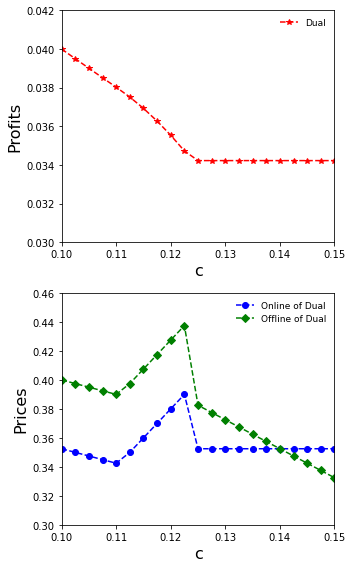

In [9]:
pon_list = []
poff_list = []
pid_list = []
for result in results:
    pon_list.append(result[0])
    poff_list.append(result[1])
    pid_list.append(result[2])
fig = plt.figure(figsize=(5, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(sel_c, pid_list, c='red', ls='--', ms=6, marker='*', label="Dual")

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(sel_c, pon_list, c='blue', ls='--', ms=6, marker='o', label="Online of Dual")
ax2.plot(sel_c, poff_list, c='green', ls='--', ms=6, marker='D',
             label="Offline of Dual")

ax1.axis(ymin=0.03,ymax=0.042)
ax2.axis(ymin=0.30,ymax=0.46)
ax1.axis(xmin=0.1,xmax=0.15)
ax2.axis(xmin=0.1,xmax=0.15)

ax1.legend(prop=dict(size=9), frameon=False)
ax1.set_ylabel("Profits", fontsize=16)
ax1.set_xlabel("c", fontsize=16)
ax2.legend(prop=dict(size=9), frameon=False)
ax2.set_ylabel("Prices", fontsize=16)
ax2.set_xlabel("c", fontsize=16)
plt.tight_layout()
plt.show()

### Test2 

In [14]:
@ray.remote
def get_dual_result(c, cr, s, h, step=0.01):
    dual_ins = dual(c=c, cr=cr, s=s, h=h, step=step)
    return dual_ins.optimal_pon, dual_ins.optimal_poff,dual_ins.optimal_profit
result_ids = []

cr = 0.32
s = 0.00
h = 0.10
step = 0.005
sel_c=np.arange(0.1, 0.2, 0.005)

for c in sel_c:
    result_ids.append(get_dual_result.remote(c=c, cr=cr, s=s, h=h, step=step))
results = ray.get(result_ids) 
ray.shutdown()

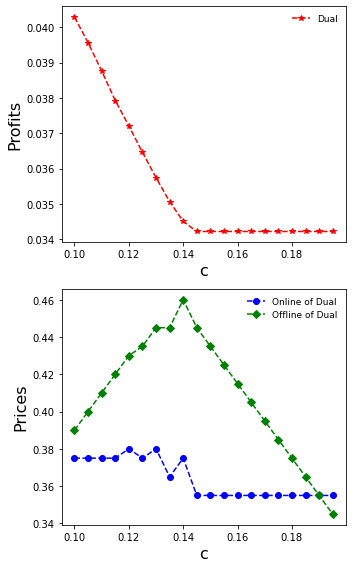

In [15]:
pon_list = []
poff_list = []
pid_list = []
for result in results:
    pon_list.append(result[0])
    poff_list.append(result[1])
    pid_list.append(result[2])
fig = plt.figure(figsize=(5, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(sel_c, pid_list, c='red', ls='--', ms=6, marker='*', label="Dual")

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(sel_c, pon_list, c='blue', ls='--', ms=6, marker='o', label="Online of Dual")
ax2.plot(sel_c, poff_list, c='green', ls='--', ms=6, marker='D',
             label="Offline of Dual")

# ax1.axis(ymin=0.03,ymax=0.042)
# ax2.axis(ymin=0.33,ymax=0.45)
# ax1.axis(xmin=0.1,xmax=0.15)
# ax2.axis(xmin=0.1,xmax=0.15)

ax1.legend(prop=dict(size=9), frameon=False)
ax1.set_ylabel("Profits", fontsize=16)
ax1.set_xlabel("c", fontsize=16)
ax2.legend(prop=dict(size=9), frameon=False)
ax2.set_ylabel("Prices", fontsize=16)
ax2.set_xlabel("c", fontsize=16)
plt.tight_layout()
plt.show()

In [4]:
logger.setLevel(logging.INFO)
res = dual(c=0.125, cr=0.32, s=0.01, h=0.09, step=0.005)

INFO:dual:Given pon=0.1100, no store demand, a RE is found: poffs: 0.0950, poff: 0.0950, prior_online:0.7350, total profit: 0.000919, scenario: 4.
INFO:dual:Given pon=0.1150, no store demand, a RE is found: poffs: 0.1050, poff: 0.1050, prior_online:0.7275, total profit: 0.002273, scenario: 4.
INFO:dual:Given pon=0.1200, no store demand, a RE is found: poffs: 0.1100, poff: 0.1100, prior_online:0.7200, total profit: 0.003600, scenario: 4.
INFO:dual:Given pon=0.1250, no store demand, a RE is found: poffs: 0.1200, poff: 0.1200, prior_online:0.7125, total profit: 0.004898, scenario: 4.
INFO:dual:Given pon=0.1300, no store demand, a RE is found: poffs: 0.1250, poff: 0.1250, prior_online:0.7050, total profit: 0.006169, scenario: 4.
INFO:dual:Given pon=0.1350, no store demand, a RE is found: poffs: 0.1350, poff: 0.1350, prior_online:0.6975, total profit: 0.007411, scenario: 4.
INFO:dual:Given pon=0.1400, no store demand, a RE is found: poffs: 0.1400, poff: 0.1400, prior_online:0.6900, total pr

INFO:dual:Given pon=0.3400, a RE is found. poffs: 0.420000, poff: 0.4200, store profit:0.00433, prior_online:0.3500, prior_store:0.0413, total profit: 0.03496, scenario: 4
INFO:dual:Given pon=0.3400, a RE is found. poffs: 0.425000, poff: 0.4250, store profit:0.00390, prior_online:0.3500, prior_store:0.0564, total profit: 0.03452, scenario: 1
INFO:dual:Given pon=0.3400, a RE is found. poffs: 0.430000, poff: 0.4300, store profit:0.00345, prior_online:0.3500, prior_store:0.0719, total profit: 0.03408, scenario: 1
INFO:dual:Given pon=0.3450, a RE is found. poffs: 0.415000, poff: 0.4150, store profit:0.00706, prior_online:0.3178, prior_store:0.0680, total profit: 0.03546, scenario: 4
INFO:dual:Given pon=0.3450, a RE is found. poffs: 0.420000, poff: 0.4200, store profit:0.00596, prior_online:0.3281, prior_store:0.0567, total profit: 0.03528, scenario: 4
INFO:dual:Given pon=0.3450, a RE is found. poffs: 0.425000, poff: 0.4250, store profit:0.00520, prior_online:0.3333, prior_store:0.0586, tot

INFO:dual:Given pon=0.3800, a RE is found. poffs: 0.460000, poff: 0.4600, store profit:0.01129, prior_online:0.2250, prior_store:0.1738, total profit: 0.03436, scenario: 1
INFO:dual:Given pon=0.3800, a RE is found. poffs: 0.465000, poff: 0.4650, store profit:0.01090, prior_online:0.2250, prior_store:0.1889, total profit: 0.03397, scenario: 1
INFO:dual:Given pon=0.3800, a RE is found. poffs: 0.470000, poff: 0.4700, store profit:0.01051, prior_online:0.2250, prior_store:0.2044, total profit: 0.03357, scenario: 1
INFO:dual:Given pon=0.3850, a RE is found. poffs: 0.440000, poff: 0.4400, store profit:0.01439, prior_online:0.2060, prior_store:0.1308, total profit: 0.03588, scenario: 4
INFO:dual:Given pon=0.3850, a RE is found. poffs: 0.445000, poff: 0.4450, store profit:0.01365, prior_online:0.2108, prior_store:0.1318, total profit: 0.03565, scenario: 1
INFO:dual:Given pon=0.3850, a RE is found. poffs: 0.450000, poff: 0.4500, store profit:0.01329, prior_online:0.2108, prior_store:0.1457, tot

INFO:dual:Given pon=0.4100, a RE is found. poffs: 0.465000, poff: 0.4650, store profit:0.01821, prior_online:0.1444, prior_store:0.1922, total profit: 0.03463, scenario: 1
INFO:dual:Given pon=0.4100, a RE is found. poffs: 0.470000, poff: 0.4700, store profit:0.01786, prior_online:0.1444, prior_store:0.2058, total profit: 0.03429, scenario: 1
INFO:dual:Given pon=0.4100, a RE is found. poffs: 0.475000, poff: 0.4750, store profit:0.01751, prior_online:0.1444, prior_store:0.2197, total profit: 0.03393, scenario: 1
INFO:dual:Given pon=0.4100, a RE is found. poffs: 0.480000, poff: 0.4800, store profit:0.01715, prior_online:0.1444, prior_store:0.2339, total profit: 0.03357, scenario: 1
INFO:dual:Given pon=0.4100, a RE is found. poffs: 0.485000, poff: 0.4850, store profit:0.01679, prior_online:0.1444, prior_store:0.2484, total profit: 0.03321, scenario: 1
INFO:dual:Given pon=0.4100, a RE is found. poffs: 0.490000, poff: 0.4900, store profit:0.01643, prior_online:0.1444, prior_store:0.2633, tot

INFO:dual:Given pon=0.4300, a RE is found. poffs: 0.515000, poff: 0.5150, store profit:0.01936, prior_online:0.0969, prior_store:0.3334, total profit: 0.03111, scenario: 1
INFO:dual:Given pon=0.4300, a RE is found. poffs: 0.520000, poff: 0.5200, store profit:0.01903, prior_online:0.0969, prior_store:0.3489, total profit: 0.03078, scenario: 1
INFO:dual:Given pon=0.4350, a RE is found. poffs: 0.470000, poff: 0.4700, store profit:0.02357, prior_online:0.0858, prior_store:0.2091, total profit: 0.03414, scenario: 1
INFO:dual:Given pon=0.4350, a RE is found. poffs: 0.475000, poff: 0.4750, store profit:0.02325, prior_online:0.0858, prior_store:0.2214, total profit: 0.03381, scenario: 1
INFO:dual:Given pon=0.4350, a RE is found. poffs: 0.480000, poff: 0.4800, store profit:0.02292, prior_online:0.0858, prior_store:0.2341, total profit: 0.03348, scenario: 1
INFO:dual:Given pon=0.4350, a RE is found. poffs: 0.485000, poff: 0.4850, store profit:0.02258, prior_online:0.0858, prior_store:0.2471, tot

INFO:dual:Given pon=0.4500, a RE is found. poffs: 0.525000, poff: 0.5250, store profit:0.02312, prior_online:0.0544, prior_store:0.3547, total profit: 0.03012, scenario: 1
INFO:dual:Given pon=0.4500, a RE is found. poffs: 0.530000, poff: 0.5300, store profit:0.02279, prior_online:0.0544, prior_store:0.3695, total profit: 0.02979, scenario: 1
INFO:dual:Given pon=0.4500, a RE is found. poffs: 0.535000, poff: 0.5350, store profit:0.02247, prior_online:0.0544, prior_store:0.3847, total profit: 0.02947, scenario: 1
INFO:dual:Given pon=0.4500, a RE is found. poffs: 0.540000, poff: 0.5400, store profit:0.02217, prior_online:0.0544, prior_store:0.4002, total profit: 0.02917, scenario: 1
INFO:dual:Given pon=0.4550, a RE is found. poffs: 0.480000, poff: 0.4800, store profit:0.02729, prior_online:0.0445, prior_store:0.2357, total profit: 0.03311, scenario: 1
INFO:dual:Given pon=0.4550, a RE is found. poffs: 0.485000, poff: 0.4850, store profit:0.02696, prior_online:0.0445, prior_store:0.2474, tot

INFO:dual:Given pon=0.4700, a RE is found. poffs: 0.495000, poff: 0.4950, store profit:0.02946, prior_online:0.0169, prior_store:0.2709, total profit: 0.03176, scenario: 1
INFO:dual:Given pon=0.4700, a RE is found. poffs: 0.500000, poff: 0.5000, store profit:0.02911, prior_online:0.0169, prior_store:0.2827, total profit: 0.03141, scenario: 1
INFO:dual:Given pon=0.4700, a RE is found. poffs: 0.505000, poff: 0.5050, store profit:0.02876, prior_online:0.0169, prior_store:0.2947, total profit: 0.03106, scenario: 1
INFO:dual:Given pon=0.4700, a RE is found. poffs: 0.510000, poff: 0.5100, store profit:0.02840, prior_online:0.0169, prior_store:0.3070, total profit: 0.03070, scenario: 1
INFO:dual:Given pon=0.4700, a RE is found. poffs: 0.515000, poff: 0.5150, store profit:0.02803, prior_online:0.0169, prior_store:0.3197, total profit: 0.03033, scenario: 1
INFO:dual:Given pon=0.4700, a RE is found. poffs: 0.520000, poff: 0.5200, store profit:0.02767, prior_online:0.0169, prior_store:0.3327, tot

INFO:dual:Given pon=0.4850, a RE is found. poffs: 0.510000, poff: 0.5100, store profit:0.03049, prior_online:0.0000, prior_store:0.2414, total profit: 0.03049, scenario: 1
INFO:dual:Given pon=0.4850, a RE is found. poffs: 0.515000, poff: 0.5150, store profit:0.03012, prior_online:0.0000, prior_store:0.2375, total profit: 0.03012, scenario: 1
INFO:dual:Given pon=0.4850, a RE is found. poffs: 0.520000, poff: 0.5200, store profit:0.02974, prior_online:0.0000, prior_store:0.2339, total profit: 0.02974, scenario: 1
INFO:dual:Given pon=0.4850, a RE is found. poffs: 0.525000, poff: 0.5250, store profit:0.02937, prior_online:0.0000, prior_store:0.2306, total profit: 0.02937, scenario: 1
INFO:dual:Given pon=0.4850, a RE is found. poffs: 0.530000, poff: 0.5300, store profit:0.02900, prior_online:0.0000, prior_store:0.2277, total profit: 0.02900, scenario: 1
INFO:dual:Given pon=0.4850, a RE is found. poffs: 0.535000, poff: 0.5350, store profit:0.02862, prior_online:0.0000, prior_store:0.2250, tot

INFO:dual:Given pon=0.5000, a RE is found. poffs: 0.525000, poff: 0.5250, store profit:0.02944, prior_online:0.0000, prior_store:0.2264, total profit: 0.02944, scenario: 1
INFO:dual:Given pon=0.5000, a RE is found. poffs: 0.530000, poff: 0.5300, store profit:0.02905, prior_online:0.0000, prior_store:0.2225, total profit: 0.02905, scenario: 1
INFO:dual:Given pon=0.5000, a RE is found. poffs: 0.535000, poff: 0.5350, store profit:0.02866, prior_online:0.0000, prior_store:0.2189, total profit: 0.02866, scenario: 1
INFO:dual:Given pon=0.5000, a RE is found. poffs: 0.540000, poff: 0.5400, store profit:0.02827, prior_online:0.0000, prior_store:0.2156, total profit: 0.02827, scenario: 1
INFO:dual:Given pon=0.5000, a RE is found. poffs: 0.545000, poff: 0.5450, store profit:0.02788, prior_online:0.0000, prior_store:0.2127, total profit: 0.02788, scenario: 1
INFO:dual:Given pon=0.5000, a RE is found. poffs: 0.550000, poff: 0.5500, store profit:0.02750, prior_online:0.0000, prior_store:0.2100, tot

INFO:dual:Given pon=0.5150, a RE is found. poffs: 0.535000, poff: 0.5350, store profit:0.02870, prior_online:0.0000, prior_store:0.2156, total profit: 0.02870, scenario: 3
INFO:dual:Given pon=0.5150, a RE is found. poffs: 0.540000, poff: 0.5400, store profit:0.02828, prior_online:0.0000, prior_store:0.2114, total profit: 0.02828, scenario: 3
INFO:dual:Given pon=0.5150, a RE is found. poffs: 0.545000, poff: 0.5450, store profit:0.02787, prior_online:0.0000, prior_store:0.2075, total profit: 0.02787, scenario: 3
INFO:dual:Given pon=0.5150, a RE is found. poffs: 0.550000, poff: 0.5500, store profit:0.02746, prior_online:0.0000, prior_store:0.2039, total profit: 0.02746, scenario: 3
INFO:dual:Given pon=0.5150, a RE is found. poffs: 0.555000, poff: 0.5550, store profit:0.02705, prior_online:0.0000, prior_store:0.2006, total profit: 0.02705, scenario: 3
INFO:dual:Given pon=0.5150, a RE is found. poffs: 0.560000, poff: 0.5600, store profit:0.02665, prior_online:0.0000, prior_store:0.1977, tot

INFO:dual:Given pon=0.5300, a RE is found. poffs: 0.550000, poff: 0.5500, store profit:0.02746, prior_online:0.0000, prior_store:0.2006, total profit: 0.02746, scenario: 3
INFO:dual:Given pon=0.5300, a RE is found. poffs: 0.555000, poff: 0.5550, store profit:0.02701, prior_online:0.0000, prior_store:0.1964, total profit: 0.02701, scenario: 3
INFO:dual:Given pon=0.5300, a RE is found. poffs: 0.560000, poff: 0.5600, store profit:0.02657, prior_online:0.0000, prior_store:0.1925, total profit: 0.02657, scenario: 3
INFO:dual:Given pon=0.5300, a RE is found. poffs: 0.565000, poff: 0.5650, store profit:0.02614, prior_online:0.0000, prior_store:0.1889, total profit: 0.02614, scenario: 3
INFO:dual:Given pon=0.5300, a RE is found. poffs: 0.570000, poff: 0.5700, store profit:0.02572, prior_online:0.0000, prior_store:0.1856, total profit: 0.02572, scenario: 3
INFO:dual:Given pon=0.5300, a RE is found. poffs: 0.575000, poff: 0.5750, store profit:0.02531, prior_online:0.0000, prior_store:0.1827, tot

INFO:dual:Given pon=0.5450, a RE is found. poffs: 0.565000, poff: 0.5650, store profit:0.02610, prior_online:0.0000, prior_store:0.1856, total profit: 0.02610, scenario: 3
INFO:dual:Given pon=0.5450, a RE is found. poffs: 0.570000, poff: 0.5700, store profit:0.02563, prior_online:0.0000, prior_store:0.1814, total profit: 0.02563, scenario: 3
INFO:dual:Given pon=0.5450, a RE is found. poffs: 0.575000, poff: 0.5750, store profit:0.02517, prior_online:0.0000, prior_store:0.1775, total profit: 0.02517, scenario: 3
INFO:dual:Given pon=0.5450, a RE is found. poffs: 0.580000, poff: 0.5800, store profit:0.02472, prior_online:0.0000, prior_store:0.1739, total profit: 0.02472, scenario: 3
INFO:dual:Given pon=0.5450, a RE is found. poffs: 0.585000, poff: 0.5850, store profit:0.02428, prior_online:0.0000, prior_store:0.1706, total profit: 0.02428, scenario: 3
INFO:dual:Given pon=0.5450, a RE is found. poffs: 0.590000, poff: 0.5900, store profit:0.02386, prior_online:0.0000, prior_store:0.1677, tot

INFO:dual:Given pon=0.5600, a RE is found. poffs: 0.580000, poff: 0.5800, store profit:0.02463, prior_online:0.0000, prior_store:0.1706, total profit: 0.02463, scenario: 3
INFO:dual:Given pon=0.5600, a RE is found. poffs: 0.585000, poff: 0.5850, store profit:0.02413, prior_online:0.0000, prior_store:0.1664, total profit: 0.02413, scenario: 3
INFO:dual:Given pon=0.5600, a RE is found. poffs: 0.590000, poff: 0.5900, store profit:0.02365, prior_online:0.0000, prior_store:0.1625, total profit: 0.02365, scenario: 3
INFO:dual:Given pon=0.5600, a RE is found. poffs: 0.595000, poff: 0.5950, store profit:0.02318, prior_online:0.0000, prior_store:0.1589, total profit: 0.02318, scenario: 3
INFO:dual:Given pon=0.5600, a RE is found. poffs: 0.600000, poff: 0.6000, store profit:0.02272, prior_online:0.0000, prior_store:0.1556, total profit: 0.02272, scenario: 3
INFO:dual:Given pon=0.5600, a RE is found. poffs: 0.605000, poff: 0.6050, store profit:0.02229, prior_online:0.0000, prior_store:0.1527, tot

INFO:dual:Given pon=0.5750, a RE is found. poffs: 0.595000, poff: 0.5950, store profit:0.02305, prior_online:0.0000, prior_store:0.1556, total profit: 0.02305, scenario: 3
INFO:dual:Given pon=0.5750, a RE is found. poffs: 0.600000, poff: 0.6000, store profit:0.02253, prior_online:0.0000, prior_store:0.1514, total profit: 0.02253, scenario: 3
INFO:dual:Given pon=0.5750, a RE is found. poffs: 0.605000, poff: 0.6050, store profit:0.02202, prior_online:0.0000, prior_store:0.1475, total profit: 0.02202, scenario: 3
INFO:dual:Given pon=0.5750, a RE is found. poffs: 0.610000, poff: 0.6100, store profit:0.02153, prior_online:0.0000, prior_store:0.1439, total profit: 0.02153, scenario: 3
INFO:dual:Given pon=0.5750, a RE is found. poffs: 0.615000, poff: 0.6150, store profit:0.02106, prior_online:0.0000, prior_store:0.1406, total profit: 0.02106, scenario: 3
INFO:dual:Given pon=0.5750, a RE is found. poffs: 0.620000, poff: 0.6200, store profit:0.02061, prior_online:0.0000, prior_store:0.1377, tot

INFO:dual:Given pon=0.5900, a RE is found. poffs: 0.610000, poff: 0.6100, store profit:0.02135, prior_online:0.0000, prior_store:0.1406, total profit: 0.02135, scenario: 3
INFO:dual:Given pon=0.5900, a RE is found. poffs: 0.615000, poff: 0.6150, store profit:0.02081, prior_online:0.0000, prior_store:0.1364, total profit: 0.02081, scenario: 3
INFO:dual:Given pon=0.5900, a RE is found. poffs: 0.620000, poff: 0.6200, store profit:0.02028, prior_online:0.0000, prior_store:0.1325, total profit: 0.02028, scenario: 3
INFO:dual:Given pon=0.5900, a RE is found. poffs: 0.625000, poff: 0.6250, store profit:0.01977, prior_online:0.0000, prior_store:0.1289, total profit: 0.01977, scenario: 3
INFO:dual:Given pon=0.5900, a RE is found. poffs: 0.630000, poff: 0.6300, store profit:0.01928, prior_online:0.0000, prior_store:0.1256, total profit: 0.01928, scenario: 3
INFO:dual:Given pon=0.5900, a RE is found. poffs: 0.635000, poff: 0.6350, store profit:0.01882, prior_online:0.0000, prior_store:0.1227, tot

INFO:dual:Given pon=0.6050, a RE is found. poffs: 0.625000, poff: 0.6250, store profit:0.01955, prior_online:0.0000, prior_store:0.1256, total profit: 0.01955, scenario: 3
INFO:dual:Given pon=0.6050, a RE is found. poffs: 0.630000, poff: 0.6300, store profit:0.01897, prior_online:0.0000, prior_store:0.1214, total profit: 0.01897, scenario: 3
INFO:dual:Given pon=0.6050, a RE is found. poffs: 0.635000, poff: 0.6350, store profit:0.01842, prior_online:0.0000, prior_store:0.1175, total profit: 0.01842, scenario: 3
INFO:dual:Given pon=0.6050, a RE is found. poffs: 0.640000, poff: 0.6400, store profit:0.01789, prior_online:0.0000, prior_store:0.1139, total profit: 0.01789, scenario: 3
INFO:dual:Given pon=0.6050, a RE is found. poffs: 0.645000, poff: 0.6450, store profit:0.01739, prior_online:0.0000, prior_store:0.1106, total profit: 0.01739, scenario: 3
INFO:dual:Given pon=0.6050, a RE is found. poffs: 0.650000, poff: 0.6500, store profit:0.01692, prior_online:0.0000, prior_store:0.1077, tot

INFO:dual:Given pon=0.6200, a RE is found. poffs: 0.640000, poff: 0.6400, store profit:0.01763, prior_online:0.0000, prior_store:0.1106, total profit: 0.01763, scenario: 3
INFO:dual:Given pon=0.6200, a RE is found. poffs: 0.645000, poff: 0.6450, store profit:0.01703, prior_online:0.0000, prior_store:0.1064, total profit: 0.01703, scenario: 3
INFO:dual:Given pon=0.6200, a RE is found. poffs: 0.650000, poff: 0.6500, store profit:0.01645, prior_online:0.0000, prior_store:0.1025, total profit: 0.01645, scenario: 3
INFO:dual:Given pon=0.6200, a RE is found. poffs: 0.655000, poff: 0.6550, store profit:0.01590, prior_online:0.0000, prior_store:0.0989, total profit: 0.01590, scenario: 3
INFO:dual:Given pon=0.6200, a RE is found. poffs: 0.660000, poff: 0.6600, store profit:0.01538, prior_online:0.0000, prior_store:0.0956, total profit: 0.01538, scenario: 3
INFO:dual:Given pon=0.6200, a RE is found. poffs: 0.665000, poff: 0.6650, store profit:0.01490, prior_online:0.0000, prior_store:0.0927, tot

INFO:dual:Given pon=0.6350, a RE is found. poffs: 0.655000, poff: 0.6550, store profit:0.01560, prior_online:0.0000, prior_store:0.0956, total profit: 0.01560, scenario: 3
INFO:dual:Given pon=0.6350, a RE is found. poffs: 0.660000, poff: 0.6600, store profit:0.01497, prior_online:0.0000, prior_store:0.0914, total profit: 0.01497, scenario: 3
INFO:dual:Given pon=0.6350, a RE is found. poffs: 0.665000, poff: 0.6650, store profit:0.01437, prior_online:0.0000, prior_store:0.0875, total profit: 0.01437, scenario: 3
INFO:dual:Given pon=0.6350, a RE is found. poffs: 0.670000, poff: 0.6700, store profit:0.01380, prior_online:0.0000, prior_store:0.0839, total profit: 0.01380, scenario: 3
INFO:dual:Given pon=0.6350, a RE is found. poffs: 0.675000, poff: 0.6750, store profit:0.01327, prior_online:0.0000, prior_store:0.0806, total profit: 0.01327, scenario: 3
INFO:dual:Given pon=0.6350, a RE is found. poffs: 0.680000, poff: 0.6800, store profit:0.01277, prior_online:0.0000, prior_store:0.0777, tot

INFO:dual:Given pon=0.6500, a RE is found. poffs: 0.670000, poff: 0.6700, store profit:0.01345, prior_online:0.0000, prior_store:0.0806, total profit: 0.01345, scenario: 3
INFO:dual:Given pon=0.6500, a RE is found. poffs: 0.675000, poff: 0.6750, store profit:0.01280, prior_online:0.0000, prior_store:0.0764, total profit: 0.01280, scenario: 3
INFO:dual:Given pon=0.6500, a RE is found. poffs: 0.680000, poff: 0.6800, store profit:0.01217, prior_online:0.0000, prior_store:0.0725, total profit: 0.01217, scenario: 3
INFO:dual:Given pon=0.6500, a RE is found. poffs: 0.685000, poff: 0.6850, store profit:0.01159, prior_online:0.0000, prior_store:0.0689, total profit: 0.01159, scenario: 3
INFO:dual:Given pon=0.6500, a RE is found. poffs: 0.690000, poff: 0.6900, store profit:0.01104, prior_online:0.0000, prior_store:0.0656, total profit: 0.01104, scenario: 3
INFO:dual:Given pon=0.6500, a RE is found. poffs: 0.695000, poff: 0.6950, store profit:0.01053, prior_online:0.0000, prior_store:0.0627, tot

INFO:dual:Given pon=0.6650, a RE is found. poffs: 0.685000, poff: 0.6850, store profit:0.01119, prior_online:0.0000, prior_store:0.0656, total profit: 0.01119, scenario: 3
INFO:dual:Given pon=0.6650, a RE is found. poffs: 0.690000, poff: 0.6900, store profit:0.01051, prior_online:0.0000, prior_store:0.0614, total profit: 0.01051, scenario: 3
INFO:dual:Given pon=0.6650, a RE is found. poffs: 0.695000, poff: 0.6950, store profit:0.00987, prior_online:0.0000, prior_store:0.0575, total profit: 0.00987, scenario: 3
INFO:dual:Given pon=0.6650, a RE is found. poffs: 0.700000, poff: 0.7000, store profit:0.00926, prior_online:0.0000, prior_store:0.0539, total profit: 0.00926, scenario: 3
INFO:dual:Given pon=0.6650, a RE is found. poffs: 0.705000, poff: 0.7050, store profit:0.00870, prior_online:0.0000, prior_store:0.0506, total profit: 0.00870, scenario: 3
INFO:dual:Given pon=0.6650, a RE is found. poffs: 0.710000, poff: 0.7100, store profit:0.00818, prior_online:0.0000, prior_store:0.0477, tot

INFO:dual:Given pon=0.6800, a RE is found. poffs: 0.715000, poff: 0.7150, store profit:0.00682, prior_online:0.0000, prior_store:0.0389, total profit: 0.00682, scenario: 3
INFO:dual:Given pon=0.6800, a RE is found. poffs: 0.720000, poff: 0.7200, store profit:0.00624, prior_online:0.0000, prior_store:0.0356, total profit: 0.00624, scenario: 3
INFO:dual:Given pon=0.6800, a RE is found. poffs: 0.725000, poff: 0.7250, store profit:0.00571, prior_online:0.0000, prior_store:0.0327, total profit: 0.00571, scenario: 3
INFO:dual:Given pon=0.6800, a RE is found. poffs: 0.730000, poff: 0.7300, store profit:0.00522, prior_online:0.0000, prior_store:0.0300, total profit: 0.00522, scenario: 3
INFO:dual:Given pon=0.6800, a RE is found. poffs: 0.735000, poff: 0.7350, store profit:0.00479, prior_online:0.0000, prior_store:0.0277, total profit: 0.00479, scenario: 3
INFO:dual:Given pon=0.6800, a RE is found. poffs: 0.740000, poff: 0.7400, store profit:0.00441, prior_online:0.0000, prior_store:0.0256, tot

INFO:dual:Given pon=0.7000, a RE is found. poffs: 0.745000, poff: 0.7450, store profit:0.00225, prior_online:0.0000, prior_store:0.0127, total profit: 0.00225, scenario: 3
INFO:dual:Given pon=0.7000, a RE is found. poffs: 0.750000, poff: 0.7500, store profit:0.00175, prior_online:0.0000, prior_store:0.0100, total profit: 0.00175, scenario: 3
INFO:dual:Given pon=0.7050, a RE is found. poffs: 0.715000, poff: 0.7150, store profit:0.00626, prior_online:0.0000, prior_store:0.0350, total profit: 0.00626, scenario: 3
INFO:dual:Given pon=0.7050, a RE is found. poffs: 0.720000, poff: 0.7200, store profit:0.00542, prior_online:0.0000, prior_store:0.0302, total profit: 0.00542, scenario: 3
INFO:dual:Given pon=0.7050, a RE is found. poffs: 0.725000, poff: 0.7250, store profit:0.00463, prior_online:0.0000, prior_store:0.0256, total profit: 0.00463, scenario: 3
INFO:dual:Given pon=0.7050, a RE is found. poffs: 0.730000, poff: 0.7300, store profit:0.00387, prior_online:0.0000, prior_store:0.0214, tot

In [21]:
c=0.12
pon=0.37
poffs=0.43
poff=0.43
s=0.00
h=0.10

scenario_prior = scenario_check(pon=pon, poffs=poffs, s=s, h=h, c=c)
print("prior demand scenario: {}".format(scenario_prior))
alpha_o, alpha_s, alpha_l=calculate_prior_demand(pon, poffs, c, s, h, scenario=scenario_prior)
print("prior online demand: {:.3f}; prior store demand: {:.3f}".format(alpha_o,alpha_s))
assert(alpha_s>0)
store_scenario = store_scenario_check(c=c,s=s, h=h,pon=pon, poffs=poffs, poff=poff, scenario=scenario_prior)
print("store demand shape: {}".format(store_scenario))
alpha_so, alpha_ss=calculate_store_demand(c=c,s=s, h=h,pon=pon, poffs=poffs, poff=poff, store_scenario=store_scenario)
print("(so, ss): {}".format((alpha_so, alpha_ss)))
print("store proit: {:.5f}".format(cal_store_profit(pon=pon, poff=poff, alpha_ss=alpha_ss, alpha_so=alpha_so)))


prior demand scenario: 1
prior online demand: 0.214; prior store demand: 0.161
store demand shape: 2
(so, ss): (0.016625000000000015, 0.13200000000000006)
store proit: 0.01573


In [12]:
pon=0.380
poffs=0.38
poff=0.38
c=0.12
s=0.04
h=0.06

scenario_prior = scenario_check(pon=pon, poffs=poffs, s=s, h=h, c=c)
print("prior demand scenario: {}".format(scenario_prior))
alpha_o, alpha_s, alpha_l=calculate_prior_demand(pon, poffs, c, s, h, scenario=scenario_prior)
print("prior online demand: {:.3f}; prior store demand: {:.3f}".format(alpha_o,alpha_s))
store_scenario = store_scenario_check(c=c,s=s, h=h,pon=pon, poffs=poffs, poff=poff, scenario=scenario_prior)
print("store demand shape: {}".format(store_scenario))
alpha_so, alpha_ss=calculate_store_demand(c=c,s=s, h=h,pon=pon, poffs=poffs, poff=poff, store_scenario=store_scenario)
print("(so, ss): {}".format((alpha_so, alpha_ss)))
print("store proit: {:.5f}".format(cal_store_profit(pon=pon, poff=poff, alpha_ss=alpha_ss, alpha_so=alpha_so)))

print("---"*40)
print("Note that the retailer has the incentive to raise the offline price to obtain higher profit. For example, by set poff=0.4")
print("---"*40)

poff=0.40
store_scenario = store_scenario_check(c=c,s=s, h=h,pon=pon, poffs=poffs, poff=poff, scenario=scenario_prior)
print("store demand shape: {}".format(store_scenario))
alpha_so, alpha_ss=calculate_store_demand(c=c,s=s, h=h,pon=pon, poffs=poffs, poff=poff, store_scenario=store_scenario)
print("(so, ss): {}".format((alpha_so, alpha_ss)))
print("store proit: {:.5f}".format(cal_store_profit(pon=pon, poff=poff, alpha_ss=alpha_ss, alpha_so=alpha_so)))

print("---"*40)
print("Therefore there is a \"hold-up\" problem")
print("---"*40)


prior demand scenario: 4
prior online demand: 0.000; prior store demand: 0.390
store demand shape: 1
(so, ss): (0, 0.39)
store proit: 0.03803
------------------------------------------------------------------------------------------------------------------------
Note that the retailer has the incentive to raise the offline price to obtain higher profit. For example, by set poff=0.4
------------------------------------------------------------------------------------------------------------------------
store demand shape: 1
(so, ss): (0.19499999999999798, 0.19500000000000203)
store proit: 0.03583
------------------------------------------------------------------------------------------------------------------------
Therefore there is a "hold-up" problem
------------------------------------------------------------------------------------------------------------------------


In [31]:
pon=0.3525
poffs=0.3725
poff=0.3725
c=0.13
s=0.049
h=0.051

scenario_prior = scenario_check(pon=pon, poffs=poffs, s=s, h=h, c=c)
print("prior demand scenario: {}".format(scenario_prior))
alpha_o, alpha_s, alpha_l=calculate_prior_demand(pon, poffs, c, s, h, scenario=scenario_prior)
print("prior online demand: {:.3f}; prior store demand: {:.3f}".format(alpha_o,alpha_s))
assert(alpha_s>0)

store_scenario = store_scenario_check(c=c,s=s, h=h,pon=pon, poffs=poffs, poff=poff, scenario=scenario_prior)
print("store demand shape: {}".format(store_scenario))
alpha_so, alpha_ss=calculate_store_demand(c=c,s=s, h=h,pon=pon, poffs=poffs, poff=poff, store_scenario=store_scenario)
print("(so, ss): {}".format((alpha_so, alpha_ss)))
print("store proit: {:.5f}".format(cal_store_profit(pon=pon, poff=poff, alpha_ss=alpha_ss, alpha_so=alpha_so)))

print("---"*30)
print("In this case, we can see poff=poffs is optimal. Both a higher store price or a lower store price bring a lower profit")
print("---"*30)

print("--- a higher poff -----")
poff=0.3925
store_scenario = store_scenario_check(c=c,s=s, h=h,pon=pon, poffs=poffs, poff=poff, scenario=scenario_prior)
print("store demand shape: {}".format(store_scenario))
alpha_so, alpha_ss=calculate_store_demand(c=c,s=s, h=h,pon=pon, poffs=poffs, poff=poff, store_scenario=store_scenario)
print("(so, ss): {}".format((alpha_so, alpha_ss)))
print("store proit: {:.5f}".format(cal_store_profit(pon=pon, poff=poff, alpha_ss=alpha_ss, alpha_so=alpha_so)))

print("--- a lower poff -----")
poff=0.3875
store_scenario = store_scenario_check(c=c,s=s, h=h,pon=pon, poffs=poffs, poff=poff, scenario=scenario_prior)
print("store demand shape: {}".format(store_scenario))
alpha_so, alpha_ss=calculate_store_demand(c=c,s=s, h=h,pon=pon, poffs=poffs, poff=poff, store_scenario=store_scenario)
print("(so, ss): {}".format((alpha_so, alpha_ss)))
print("store proit: {:.5f}".format(cal_store_profit(pon=pon, poff=poff, alpha_ss=alpha_ss, alpha_so=alpha_so)))

prior demand scenario: 4
prior online demand: 0.371; prior store demand: 0.000


AssertionError: 

In [29]:
print(poffs,1/2*pon+2*c)
print(2*c-1/2*pon, 1/2*poffs-3/4*pon+c,poffs-pon)
print(s, 1/2*poffs-3/4*pon+c,h)

0.37 0.43625
0.08375000000000002 0.05062500000000003 0.017500000000000016
0.049 0.05062500000000003 0.051
